# Lib

In [1]:
from sklearn.feature_selection import RFE
from sklearn.model_selection import train_test_split
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
import random
from imblearn.over_sampling import ADASYN
import sklearn
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer, KNNImputer
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler, LabelEncoder, PolynomialFeatures
from sklearn.feature_selection import SelectFromModel
from sklearn.decomposition import PCA
from imblearn.over_sampling import SMOTE
from sklearn.linear_model import LogisticRegression, Lasso, LassoCV
from collections import Counter
import xgboost as xgb
from xgboost import XGBClassifier
from catboost import CatBoostClassifier
from sklearn.metrics import accuracy_score, classification_report, roc_auc_score, confusion_matrix
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
import optuna
import shap
def set_seed(seed):
    random.seed(seed)
    np.random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    print(f"Seed set to {seed}")
set_seed(42)

Seed set to 42


In [2]:
train = pd.read_csv('D:/Data Quest Challenge DSI/training_dataset.csv')
test = pd.read_csv('D:/Data Quest Challenge DSI/validation_set.csv')

train.drop(['customer_number'], inplace=True, axis=1)
test.drop(['customer_number'], inplace=True, axis=1)

In [3]:
print(train.info())
print(test.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 22916 entries, 0 to 22915
Data columns (total 21 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   usia                          22916 non-null  int64  
 1   pekerjaan                     22916 non-null  object 
 2   status_perkawinan             22916 non-null  object 
 3   pendidikan                    22916 non-null  object 
 4   gagal_bayar_sebelumnya        22916 non-null  object 
 5   pinjaman_rumah                22916 non-null  object 
 6   pinjaman_pribadi              22916 non-null  object 
 7   jenis_kontak                  22916 non-null  object 
 8   bulan_kontak_terakhir         22916 non-null  object 
 9   hari_kontak_terakhir          22916 non-null  object 
 10  jumlah_kontak_kampanye_ini    22916 non-null  int64  
 11  hari_sejak_kontak_sebelumnya  22916 non-null  int64  
 12  jumlah_kontak_sebelumnya      22916 non-null  int64  
 13  h

In [4]:
# Check for missing values in both train and test datasets
print("Missing values in training dataset:")
print(train.isna().sum())

print("\nMissing values in validation dataset:")
print(test.isna().sum())

# Print total number of rows with missing values in each dataset
print("\nTotal rows with missing values:")
print(f"Training dataset: {train.isna().any(axis=1).sum()} out of {train.shape[0]} rows")
print(f"Validation dataset: {test.isna().any(axis=1).sum()} out of {test.shape[0]} rows")

Missing values in training dataset:
usia                            0
pekerjaan                       0
status_perkawinan               0
pendidikan                      0
gagal_bayar_sebelumnya          0
pinjaman_rumah                  0
pinjaman_pribadi                0
jenis_kontak                    0
bulan_kontak_terakhir           0
hari_kontak_terakhir            0
jumlah_kontak_kampanye_ini      0
hari_sejak_kontak_sebelumnya    0
jumlah_kontak_sebelumnya        0
hasil_kampanye_sebelumnya       0
tingkat_variasi_pekerjaan       0
indeks_harga_konsumen           0
indeks_kepercayaan_konsumen     0
suku_bunga_euribor_3bln         0
jumlah_pekerja                  0
pulau                           0
berlangganan_deposito           0
dtype: int64

Missing values in validation dataset:
usia                            0
pekerjaan                       0
status_perkawinan               0
pendidikan                      0
gagal_bayar_sebelumnya          0
pinjaman_rumah              

# EDA

gagal_bayar_sebelumnya cuman ada 2 baris yang classnya yes

In [5]:
train.head()

,usia,pekerjaan,status_perkawinan,pendidikan,gagal_bayar_sebelumnya,pinjaman_rumah,pinjaman_pribadi,jenis_kontak,bulan_kontak_terakhir,hari_kontak_terakhir,...,hari_sejak_kontak_sebelumnya,jumlah_kontak_sebelumnya,hasil_kampanye_sebelumnya,tingkat_variasi_pekerjaan,indeks_harga_konsumen,indeks_kepercayaan_konsumen,suku_bunga_euribor_3bln,jumlah_pekerja,pulau,berlangganan_deposito
0,63,sosial media specialis,menikah,Pendidikan Tinggi,no,yes,no,cellular,jul,fri,...,999,0,nonexistent,-1.7,94.215,-40.3,0.885,4991.6,Papua,1
1,43,teknisi,menikah,Pendidikan Tinggi,no,yes,no,cellular,nov,fri,...,999,0,nonexistent,-0.1,93.200,-42.0,4.021,5195.8,Sulawesi,0
2,29,sosial media specialis,lajang,Pendidikan Tinggi,no,yes,yes,cellular,jul,thu,...,999,0,nonexistent,1.4,93.918,-42.7,4.958,5228.1,Papua,0
3,40,pekerja kasar,menikah,SMA,no,no,no,telephone,may,wed,...,999,0,nonexistent,1.1,93.994,-36.4,4.859,5191.0,Sumatera,1
4,40,sosial media specialis,lajang,Pendidikan Tinggi,no,no,no,cellular,aug,wed,...,999,0,nonexistent,1.4,93.444,-36.1,4.964,5228.1,Bali,0


there's no class for yes

In [6]:
test.head()

,usia,pekerjaan,status_perkawinan,pendidikan,gagal_bayar_sebelumnya,pinjaman_rumah,pinjaman_pribadi,jenis_kontak,bulan_kontak_terakhir,hari_kontak_terakhir,jumlah_kontak_kampanye_ini,hari_sejak_kontak_sebelumnya,jumlah_kontak_sebelumnya,hasil_kampanye_sebelumnya,tingkat_variasi_pekerjaan,indeks_harga_konsumen,indeks_kepercayaan_konsumen,suku_bunga_euribor_3bln,jumlah_pekerja,pulau
0,35,penyedia jasa,menikah,SMA,no,yes,yes,cellular,jul,mon,1,999,0,nonexistent,1.4,93.918,-42.7,4.960,5228.1,Jawa
1,52,teknisi,lajang,Diploma,unknown,no,no,telephone,may,thu,4,999,0,nonexistent,1.1,93.994,-36.4,4.860,5191.0,Papua
2,37,pekerja kasar,menikah,SMP,unknown,yes,no,telephone,may,wed,3,999,0,nonexistent,1.1,93.994,-36.4,4.856,5191.0,Bali
3,51,pengangguran,menikah,Diploma,no,no,no,telephone,may,tue,3,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,Sumatera
4,45,teknisi,cerai,SMA,no,yes,no,cellular,may,thu,1,999,1,failure,-1.8,92.893,-46.2,1.327,5099.1,Sumatera


In [7]:
cat_col = test.select_dtypes(include=['object']).columns.tolist()
num_col = test.select_dtypes(exclude=['object']).columns.tolist()

print("Categorical columns:", cat_col)
print(f"Jumlah kolom kategorikal: { len(cat_col) }\n")

print("Numerical columns:", num_col)
print("Jumlah kolom numerikal:", len(num_col))

Categorical columns: ['pekerjaan', 'status_perkawinan', 'pendidikan', 'gagal_bayar_sebelumnya', 'pinjaman_rumah', 'pinjaman_pribadi', 'jenis_kontak', 'bulan_kontak_terakhir', 'hari_kontak_terakhir', 'hasil_kampanye_sebelumnya', 'pulau']
Jumlah kolom kategorikal: 11

Numerical columns: ['usia', 'jumlah_kontak_kampanye_ini', 'hari_sejak_kontak_sebelumnya', 'jumlah_kontak_sebelumnya', 'tingkat_variasi_pekerjaan', 'indeks_harga_konsumen', 'indeks_kepercayaan_konsumen', 'suku_bunga_euribor_3bln', 'jumlah_pekerja']
Jumlah kolom numerikal: 9


Unique Value pendidikan: ['Pendidikan Tinggi' 'SMA' 'Tidak Tamat SD' 'SMP' 'Diploma' 'SD' 'unknown'
 'TIDAK SEKOLAH']
Unique Value pekerjaan: ['sosial media specialis' 'teknisi' 'pekerja kasar' 'manajer'
 'asisten rumah tangga' 'mahasiswa' 'penyedia jasa' 'pemilik bisnis'
 'entrepreneur' 'pengangguran' 'pensiunan' 'unknown']
Unique Value status_perkawinan: ['menikah' 'lajang' 'cerai' 'unknown']
Unique Value bulan_kontak_terakhir: ['jul' 'nov' 'may' 'aug' 'oct' 'apr' 'jun' 'sep' 'mar' 'dec']
Unique Value hari_kontak_terakhir: ['fri' 'thu' 'wed' 'tue' 'mon']
Unique Value pulau: ['Papua' 'Sulawesi' 'Sumatera' 'Bali' 'NTT' 'Jawa' 'NTB' 'Kalimantan']


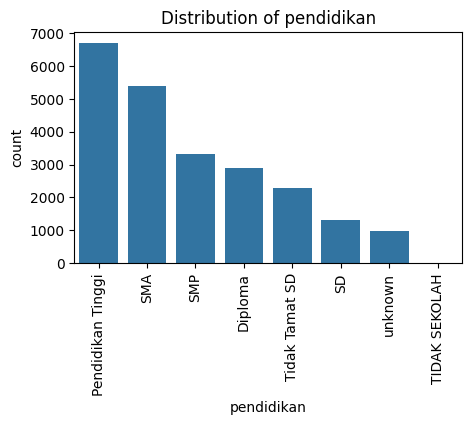

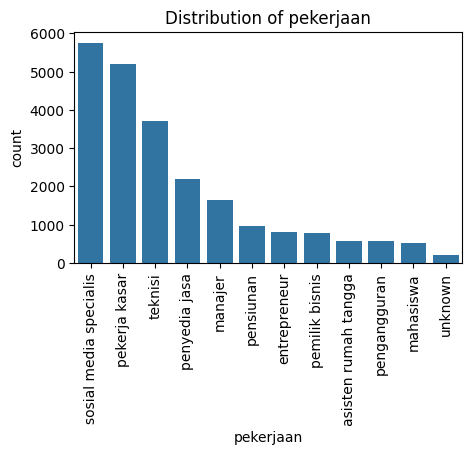

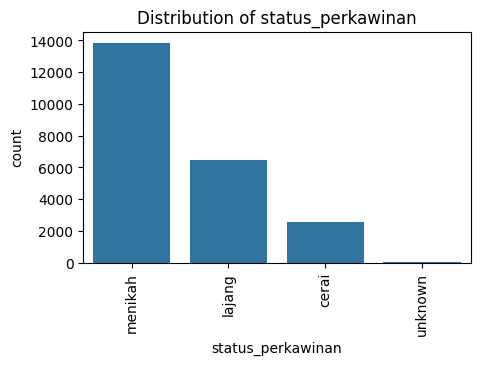

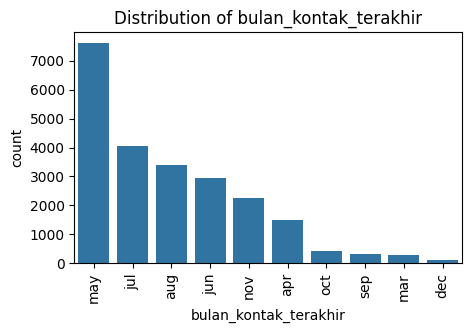

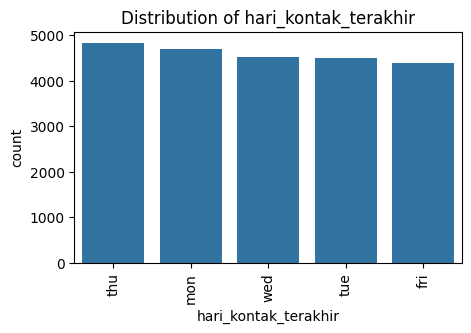

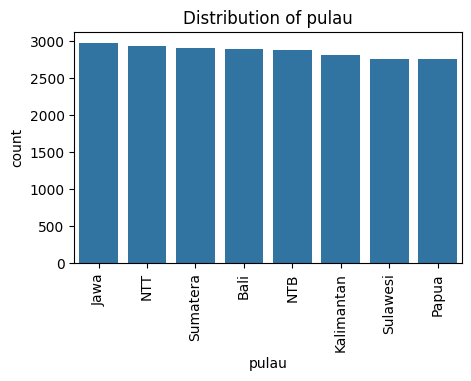

In [8]:
print("Unique Value pendidikan:", train['pendidikan'].unique())
print("Unique Value pekerjaan:", train['pekerjaan'].unique())
print("Unique Value status_perkawinan:", train['status_perkawinan'].unique())
print("Unique Value bulan_kontak_terakhir:", train['bulan_kontak_terakhir'].unique())
print("Unique Value hari_kontak_terakhir:", train['hari_kontak_terakhir'].unique())
print("Unique Value pulau:", train['pulau'].unique())

# Lookin the distribution of each categorical variable
def plot_categorical_distribution(df, column):
    plt.figure(figsize=(5, 3))
    sns.countplot(data=df, x=column, order=df[column].value_counts().index)
    plt.title(f'Distribution of {column}')
    plt.xticks(rotation=90)
    plt.show()

plot_categorical_distribution(train, 'pendidikan')
plot_categorical_distribution(train, 'pekerjaan')
plot_categorical_distribution(train, 'status_perkawinan')
plot_categorical_distribution(train, 'bulan_kontak_terakhir')
plot_categorical_distribution(train, 'hari_kontak_terakhir')
plot_categorical_distribution(train, 'pulau')

## Transforming values

Merubah semua kategori unknown menjadi NaN

In [9]:
# Replace unknown values with NaN
train['pendidikan'] = train['pendidikan'].replace(['unknown'], np.nan)
train['pekerjaan'] = train['pekerjaan'].replace(['unknown'], np.nan)
train['status_perkawinan'] = train['status_perkawinan'].replace(['unknown'], np.nan)
train['gagal_bayar_sebelumnya'] = train['gagal_bayar_sebelumnya'].replace(['unknown'], np.nan)
train['pinjaman_rumah'] = train['pinjaman_rumah'].replace(['unknown'], np.nan)
train['pinjaman_pribadi'] = train['pinjaman_pribadi'].replace(['unknown'], np.nan)
train['pinjaman_pribadi'] = train['pinjaman_pribadi'].replace(['unknown'], np.nan)

test['pendidikan'] = test['pendidikan'].replace(['unknown'], np.nan)
test['pekerjaan'] = test['pekerjaan'].replace(['unknown'], np.nan)
test['status_perkawinan'] = test['status_perkawinan'].replace(['unknown'], np.nan)
test['gagal_bayar_sebelumnya'] = test['gagal_bayar_sebelumnya'].replace(['unknown'], np.nan)
test['pinjaman_rumah'] = test['pinjaman_rumah'].replace(['unknown'], np.nan)
test['pinjaman_pribadi'] = test['pinjaman_pribadi'].replace(['unknown'], np.nan)

# Replace 999 with 0
train['hari_sejak_kontak_sebelumnya'] = train['hari_sejak_kontak_sebelumnya'].replace([999], 0)
test['hari_sejak_kontak_sebelumnya'] = test['hari_sejak_kontak_sebelumnya'].replace([999], 0)

In [10]:
print("Missing values in training dataset:")
print(train.isna().sum())
print("Duplicate rows in training dataset:")
print(train.duplicated().sum())

Missing values in training dataset:
usia                               0
pekerjaan                        193
status_perkawinan                 47
pendidikan                       992
gagal_bayar_sebelumnya          4745
pinjaman_rumah                   579
pinjaman_pribadi                 579
jenis_kontak                       0
bulan_kontak_terakhir              0
hari_kontak_terakhir               0
jumlah_kontak_kampanye_ini         0
hari_sejak_kontak_sebelumnya       0
jumlah_kontak_sebelumnya           0
hasil_kampanye_sebelumnya          0
tingkat_variasi_pekerjaan          0
indeks_harga_konsumen              0
indeks_kepercayaan_konsumen        0
suku_bunga_euribor_3bln            0
jumlah_pekerja                     0
pulau                              0
berlangganan_deposito              0
dtype: int64
Duplicate rows in training dataset:
78


In [11]:
print("\nMissing values in validation dataset:")
print(test.isna().sum())
print("Duplicate rows in validation dataset:")
print(test.duplicated().sum())


Missing values in validation dataset:
usia                               0
pekerjaan                         49
status_perkawinan                  9
pendidikan                       218
gagal_bayar_sebelumnya          1207
pinjaman_rumah                   125
pinjaman_pribadi                 125
jenis_kontak                       0
bulan_kontak_terakhir              0
hari_kontak_terakhir               0
jumlah_kontak_kampanye_ini         0
hari_sejak_kontak_sebelumnya       0
jumlah_kontak_sebelumnya           0
hasil_kampanye_sebelumnya          0
tingkat_variasi_pekerjaan          0
indeks_harga_konsumen              0
indeks_kepercayaan_konsumen        0
suku_bunga_euribor_3bln            0
jumlah_pekerja                     0
pulau                              0
dtype: int64
Duplicate rows in validation dataset:
7


# Preprocessing

In [12]:
train.drop_duplicates(inplace=True)
train.reset_index(drop=True, inplace=True)
print("Duplicate rows in training dataset after removal:")
print(train.duplicated().sum())
print("Duplicate rows in validation dataset after removal:")
print(test.duplicated().sum())

Duplicate rows in training dataset after removal:
0
Duplicate rows in validation dataset after removal:
7


Outliers checking

In [13]:
# Check for numerical columns 
num_cols = train.select_dtypes(include=['int64', 'float64']).columns

print("Numerical columns in training dataset:", num_cols)

Numerical columns in training dataset: Index(['usia', 'jumlah_kontak_kampanye_ini', 'hari_sejak_kontak_sebelumnya',
       'jumlah_kontak_sebelumnya', 'tingkat_variasi_pekerjaan',
       'indeks_harga_konsumen', 'indeks_kepercayaan_konsumen',
       'suku_bunga_euribor_3bln', 'jumlah_pekerja', 'berlangganan_deposito'],
      dtype='object')


<Axes: ylabel='jumlah_pekerja'>

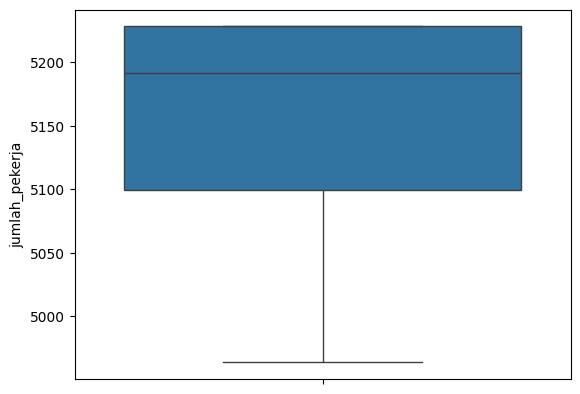

In [14]:
sns.boxplot(train['jumlah_pekerja'])

In [15]:
# Threshold atas
def replace_values_above_threshold(data_train, column, threshold):
    sns.boxplot(data_train[column])
    plt.title(f'Original Box Plot of {column}')
    plt.show()

    above_threshold = data_train[column] > threshold
    data_train.loc[above_threshold, column] = threshold

    sns.boxplot(data_train[column])
    plt.title(f'Box Plot with Values Replaced above {threshold}')
    plt.show()

    return train

# train = replace_values_above_threshold(train, 'usia', 68)
# train = replace_values_above_threshold(train, 'jumlah_kontak_kampanye_ini', 6)
# train = replace_values_above_threshold(train, 'indeks_kepercayaan_konsumen', -30)

## Encoding

In [16]:
le = LabelEncoder()

# One-hot encoding for categorical variables
def one_hot_encode(df, columns):
    return pd.get_dummies(df, columns=columns, drop_first=True)

# Mapping Ordinal Columns
pendidikan_mapping = {
    'TIDAK SEKOLAH': 0,
    'Tidak Tamat SD': 1,
    'SD': 2,
    'SMP': 3,
    'SMA': 4,
    'Diploma': 5,
    'Pendidikan Tinggi': 6,
}

bulan_kontak_mapping = {
    'jan': 1, 'feb': 2, 'mar': 3, 'apr': 4, 'may': 5, 'jun': 6,
    'jul': 7, 'aug': 8, 'sep': 9, 'oct': 10, 'nov': 11, 'dec': 12
}

hasil_mapping = {
    'failure': -1,
    'nonexistent': 0,
    'success': 1,
}

hari_kontak_mapping = {
    'mon': 1, 'tue': 2, 'wed': 3, 'thu': 4, 'fri': 5
}

binary_mapping = {
    'yes': 1,
    'no': 0
}

train['pendidikan'] = train['pendidikan'].map(pendidikan_mapping)
test['pendidikan'] = test['pendidikan'].map(pendidikan_mapping)

train['bulan_kontak_terakhir'] = train['bulan_kontak_terakhir'].map(bulan_kontak_mapping)
test['bulan_kontak_terakhir'] = test['bulan_kontak_terakhir'].map(bulan_kontak_mapping)

train['hasil_kampanye_sebelumnya'] = train['hasil_kampanye_sebelumnya'].map(hasil_mapping)
test['hasil_kampanye_sebelumnya'] = test['hasil_kampanye_sebelumnya'].map(hasil_mapping)

train['hari_kontak_terakhir'] = train['hari_kontak_terakhir'].map(hari_kontak_mapping)
test['hari_kontak_terakhir'] = test['hari_kontak_terakhir'].map(hari_kontak_mapping)

train[['pinjaman_rumah', 'pinjaman_pribadi', 'gagal_bayar_sebelumnya']] = train[['pinjaman_rumah', 'pinjaman_pribadi', 'gagal_bayar_sebelumnya']].replace(binary_mapping)
test[['pinjaman_rumah', 'pinjaman_pribadi', 'gagal_bayar_sebelumnya']] = test[['pinjaman_rumah', 'pinjaman_pribadi', 'gagal_bayar_sebelumnya']].replace(binary_mapping)

# train = one_hot_encode(train, ['pulau', 'jenis_kontak', 'status_perkawinan'])
# test = one_hot_encode(test, ['pulau', 'jenis_kontak', 'status_perkawinan'])
# train = one_hot_encode(train, ['pekerjaan'])
# test = one_hot_encode(test, ['pekerjaan'])

for col in cat_col:
    if col in train.columns:
        train[col] = le.fit_transform(train[col])
    if col in test.columns:
        test[col] = le.transform(test[col])

train = train.astype('float32')
test = test.astype('float32')

C:\Users\asus0\AppData\Local\Temp\ipykernel_36936\3327970737.py:50: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  train[['pinjaman_rumah', 'pinjaman_pribadi', 'gagal_bayar_sebelumnya']] = train[['pinjaman_rumah', 'pinjaman_pribadi', 'gagal_bayar_sebelumnya']].replace(binary_mapping)
C:\Users\asus0\AppData\Local\Temp\ipykernel_36936\3327970737.py:51: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  test[['pinjaman_rumah', 'pinjaman_pribadi', 'gagal_bayar_sebelumnya']] = test[['pinjaman_rumah', 'pinjaman_pribadi', 'gagal_bayar_sebelumn

In [17]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 22838 entries, 0 to 22837
Data columns (total 21 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   usia                          22838 non-null  float32
 1   pekerjaan                     22838 non-null  float32
 2   status_perkawinan             22838 non-null  float32
 3   pendidikan                    22838 non-null  float32
 4   gagal_bayar_sebelumnya        22838 non-null  float32
 5   pinjaman_rumah                22838 non-null  float32
 6   pinjaman_pribadi              22838 non-null  float32
 7   jenis_kontak                  22838 non-null  float32
 8   bulan_kontak_terakhir         22838 non-null  float32
 9   hari_kontak_terakhir          22838 non-null  float32
 10  jumlah_kontak_kampanye_ini    22838 non-null  float32
 11  hari_sejak_kontak_sebelumnya  22838 non-null  float32
 12  jumlah_kontak_sebelumnya      22838 non-null  float32
 13  h

## Handling missing values

### Dropping

In [18]:
train_dropped = train.dropna(axis=0, how='any')
print("\nTraining dataset after dropping rows with missing values:")
print(f'Ukuran dataset sebelum drop: {train.shape} dan ukuran dataset setelah drop: {train_dropped.shape}')

test_dropped = test.dropna(axis=0, how='any')
print("\nValidation dataset after dropping rows with missing values:")
print(f'Ukuran dataset sebelum drop: {test.shape} dan ukuran dataset setelah drop: {test_dropped.shape}')


Training dataset after dropping rows with missing values:
Ukuran dataset sebelum drop: (22838, 21) dan ukuran dataset setelah drop: (22838, 21)

Validation dataset after dropping rows with missing values:
Ukuran dataset sebelum drop: (5729, 20) dan ukuran dataset setelah drop: (5729, 20)


### MICE/KNN

In [19]:
feature_cols = train_dropped.drop(['berlangganan_deposito'], axis=1).columns.tolist()

In [20]:
# Initialize imputers
mice = IterativeImputer(random_state=42)
knn = KNNImputer(n_neighbors=5, weights='uniform', metric='nan_euclidean')

# Fit MICE imputer on training data and transform both datasets
train_imputed = mice.fit_transform(train[feature_cols])
test_imputed = mice.transform(test)

# Convert back to DataFrame with original column names
train_imputed = pd.DataFrame(train_imputed, columns=train.drop(columns=['berlangganan_deposito']).columns)
train_imputed['berlangganan_deposito'] = train['berlangganan_deposito'].values
test_imputed = pd.DataFrame(test_imputed, columns=test.columns)

# Print shape of imputed datasets
print(f"Training dataset after imputation: {train_imputed.shape}")
print(f"Test dataset after imputation: {test_imputed.shape}")

Training dataset after imputation: (22838, 21)
Test dataset after imputation: (5729, 20)


# Splitting

In [21]:
X = train_imputed.drop(columns=['berlangganan_deposito'])
y = train_imputed['berlangganan_deposito']

In [22]:
poly = PolynomialFeatures(degree=2, interaction_only=True, include_bias=False)
def create_polynomial_features(df, poly):
    poly_features = poly.fit_transform(df.select_dtypes(include=[np.number]))
    poly_feature_names = poly.get_feature_names_out(df.select_dtypes(include=[np.number]).columns)
    poly_df = pd.DataFrame(poly_features, columns=poly_feature_names)
    return poly_df
 
X_poly = poly.fit_transform(X.select_dtypes(include=[np.number]))
X_poly = pd.DataFrame(X_poly, columns=poly.get_feature_names_out(X.select_dtypes(include=[np.number]).columns))
X_poly = pd.concat([X.drop(columns=X.select_dtypes(include=[np.number]).columns), X_poly], axis=1)

test_poly = poly.transform(test_imputed.select_dtypes(include=[np.number]))
test_poly = pd.DataFrame(test_poly, columns=poly.get_feature_names_out(test_imputed.select_dtypes(include=[np.number]).columns))
test_poly = pd.concat([test_imputed.drop(columns=test_imputed.select_dtypes(include=[np.number]).columns), test_poly], axis=1)

In [23]:
X_poly.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 22838 entries, 0 to 22837
Columns: 210 entries, usia to jumlah_pekerja pulau
dtypes: float32(210)
memory usage: 18.3 MB


In [24]:
X_poly

,usia,pekerjaan,status_perkawinan,pendidikan,gagal_bayar_sebelumnya,pinjaman_rumah,pinjaman_pribadi,jenis_kontak,bulan_kontak_terakhir,hari_kontak_terakhir,...,indeks_harga_konsumen indeks_kepercayaan_konsumen,indeks_harga_konsumen suku_bunga_euribor_3bln,indeks_harga_konsumen jumlah_pekerja,indeks_harga_konsumen pulau,indeks_kepercayaan_konsumen suku_bunga_euribor_3bln,indeks_kepercayaan_konsumen jumlah_pekerja,indeks_kepercayaan_konsumen pulau,suku_bunga_euribor_3bln jumlah_pekerja,suku_bunga_euribor_3bln pulau,jumlah_pekerja pulau
0,63.0,9.0,2.0,6.0,0.0,1.0,0.0,0.0,4.0,4.0,...,-3796.864258,83.380272,470283.59375,471.074982,-35.665501,-201161.484375,-201.500000,4417.565918,4.425000,24958.000000
1,43.0,10.0,2.0,6.0,0.0,1.0,0.0,0.0,8.0,4.0,...,-3914.399902,374.757172,484248.53125,559.199951,-168.881989,-218223.593750,-252.000000,20892.310547,24.125999,31174.798828
2,29.0,9.0,1.0,6.0,0.0,1.0,1.0,0.0,4.0,3.0,...,-4010.298584,465.645447,491012.68750,469.589996,-211.706604,-223239.875000,-213.500000,25920.921875,24.790001,26140.500000
3,40.0,4.0,2.0,4.0,0.0,0.0,0.0,1.0,2.0,2.0,...,-3421.381836,456.716888,487922.87500,657.958008,-176.867615,-188952.406250,-254.800018,25223.070312,34.013000,36337.000000
4,40.0,9.0,1.0,6.0,0.0,0.0,0.0,0.0,5.0,2.0,...,-3373.328369,463.856049,488534.59375,0.000000,-179.200394,-188734.406250,-0.000000,25952.291016,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
22833,32.0,10.0,2.0,5.0,0.0,1.0,0.0,0.0,5.0,2.0,...,-3373.328369,464.136353,488534.59375,186.888000,-179.308685,-188734.406250,-72.199997,25967.972656,9.934000,10456.200195
22834,30.0,2.0,1.0,5.0,0.0,0.0,0.0,1.0,6.0,1.0,...,-3532.462402,82.895119,467566.15625,0.000000,-33.000000,-186135.000000,-0.000000,4367.968262,0.000000,0.000000
22835,29.0,3.0,1.0,4.0,0.0,1.0,0.0,0.0,4.0,2.0,...,-4010.298584,466.021088,491012.68750,375.671997,-211.877396,-223239.875000,-170.800003,25941.832031,19.848000,20912.400391
22836,52.0,1.0,2.0,1.0,2.0,1.0,0.0,1.0,3.0,0.0,...,-3948.636719,468.546387,493872.46875,283.394989,-207.328003,-218534.578125,-125.399994,25931.376953,14.880000,15684.300781


In [25]:
X_train, X_val, y_train, y_val = train_test_split(X_poly, y, test_size=0.25, stratify=y, random_state=42, shuffle=True) 

# Scaling

In [26]:
minmax = MinMaxScaler(feature_range=(0, 1))
robust = RobustScaler()
X_train_scaled = robust.fit_transform(X_train)
X_val_scaled = robust.transform(X_val)
test_scaled = robust.transform(test_poly)

X_train_scaled = pd.DataFrame(X_train_scaled, columns=X_train.columns)
X_val_scaled = pd.DataFrame(X_val_scaled, columns=X_val.columns)
test_scaled = pd.DataFrame(test_scaled, columns=test_poly.columns)

X_train_scaled[cat_col] = X_train_scaled[cat_col].astype('int32')
X_val_scaled[cat_col] = X_val_scaled[cat_col].astype('int32')
test_scaled[cat_col] = test_scaled[cat_col].astype('int32')

# Resampling

## Over under

In [27]:
# # OVER UNDER

# from imblearn.under_sampling import RandomUnderSampler
# from imblearn.over_sampling import RandomOverSampler

# # Inisialisasi undersampler untuk kelas 0
# undersampler = RandomUnderSampler(sampling_strategy={0: 5000}, random_state=42)
# # Inisialisasi oversampler untuk kelas 1 dan 2
# oversampler = RandomOverSampler(sampling_strategy={1: 2000, 0: 5000}, random_state=42)

# X_train_resampled, y_train_resampled = undersampler.fit_resample(X_train, y_train)

# X_train_final, y_train_final = oversampler.fit_resample(X_train_resampled, y_train_resampled)

# from collections import Counter
# print("Distribusi kelas setelah resampling:", Counter(y_train_final['coppaRisk']))

# X_train = X_train_final
# y_train = y_train_final

## SMOTE

In [28]:
# smote = SMOTE(random_state=42, sampling_strategy='auto')
# X_train_resampled, y_train_resampled = smote.fit_resample(X_train_scaled, y_train)
# X_val_resampled, y_val_resampled = smote.fit_resample(X_val_scaled, y_val)
# print("Distribusi kelas setelah SMOTE:")
# print(Counter(y_train_resampled))
# X_train_resampled = pd.DataFrame(X_train_resampled, columns=X_train.columns)
# X_val_resampled = pd.DataFrame(X_val_resampled, columns=X_val.columns)

# Modelling

## Training

In [29]:
# # Use elasticnet with saga solver and specify l1_ratio
# # For elasticnet, we need to specify both solver='saga' and l1_ratio parameter
# model3 = LogisticRegression(penalty='elasticnet', solver='saga', l1_ratio=0.5, max_iter=1000, random_state=42)
# model3.fit(X_train_scaled, y_train)

In [30]:
model2 = CatBoostClassifier(eval_metric='AUC', cat_features=cat_col, random_seed=42, verbose=0)
model2.fit(X_train_scaled, y_train, eval_set=(X_val_scaled, y_val))

In [31]:
# Train the model
model1 = XGBClassifier(objective="binary:logistic", eval_metric="auc", loss='logloss', random_state=42, use_label_encoder=False, verbosity=0)
model1.fit(X_train_scaled, y_train, eval_set=[(X_val_scaled, y_val)], verbose=True)

d:\Anaconda\envs\tf2\lib\site-packages\xgboost\sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")


[0]	validation_0-auc:0.77867
[1]	validation_0-auc:0.78132
[2]	validation_0-auc:0.78103
[3]	validation_0-auc:0.78440
[4]	validation_0-auc:0.78524
[5]	validation_0-auc:0.78779
[6]	validation_0-auc:0.79138
[7]	validation_0-auc:0.79303
[8]	validation_0-auc:0.79082
[9]	validation_0-auc:0.78991
[10]	validation_0-auc:0.78919
[11]	validation_0-auc:0.78759
[12]	validation_0-auc:0.78552
[13]	validation_0-auc:0.78464
[14]	validation_0-auc:0.78490
[15]	validation_0-auc:0.78402
[16]	validation_0-auc:0.78450
[17]	validation_0-auc:0.78366
[18]	validation_0-auc:0.78291
[19]	validation_0-auc:0.78288
[20]	validation_0-auc:0.78322
[21]	validation_0-auc:0.78448
[22]	validation_0-auc:0.78408
[23]	validation_0-auc:0.78417
[24]	validation_0-auc:0.78360
[25]	validation_0-auc:0.78314
[26]	validation_0-auc:0.78244
[27]	validation_0-auc:0.78218
[28]	validation_0-auc:0.78224
[29]	validation_0-auc:0.78236
[30]	validation_0-auc:0.78251
[31]	validation_0-auc:0.78258
[32]	validation_0-auc:0.78410
[33]	validation_0-au

AttributeError: 'super' object has no attribute '__sklearn_tags__'

AttributeError: 'super' object has no attribute '__sklearn_tags__'

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='auc', feature_types=None,
              gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, loss='logloss',
              max_bin=None, max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=None, num_parallel_tree=None,
              predictor=None, ...)

<Figure size 1000x800 with 0 Axes>

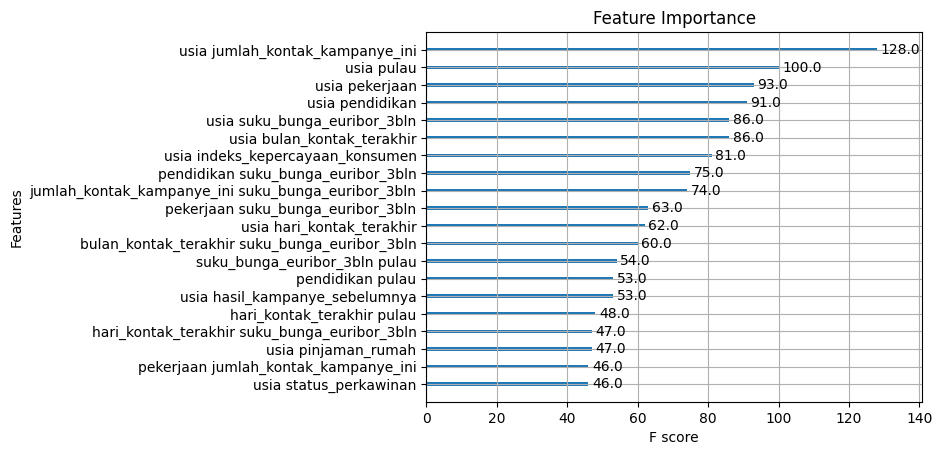

In [32]:
from xgboost import plot_importance
plt.figure(figsize=(10, 8))
plot_importance(model1, max_num_features=20, importance_type='weight', title='Feature Importance')
plt.show()

## Evaluating

Accuracy: 0.8986
ROC AUC Score: 0.7899

Classification Report:
              precision    recall  f1-score   support

         0.0       0.91      0.98      0.94      5057
         1.0       0.62      0.29      0.39       653

    accuracy                           0.90      5710
   macro avg       0.77      0.63      0.67      5710
weighted avg       0.88      0.90      0.88      5710


Confusion Matrix:
[[4944  113]
 [ 466  187]]


<Axes: >

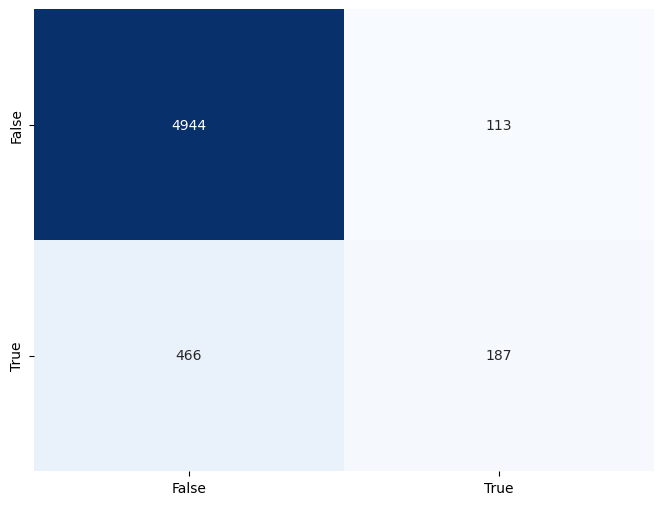

In [33]:
# Make predictions
y_pred = model2.predict(X_val_scaled)
y_pred_proba = model2.predict_proba(X_val_scaled)[:,1]

# Evaluate the model
accuracy = accuracy_score(y_val, y_pred)
roc_auc = roc_auc_score(y_val, y_pred_proba)
conf_matrix = confusion_matrix(y_val, y_pred)

print(f"Accuracy: {accuracy:.4f}")
print(f"ROC AUC Score: {roc_auc:.4f}")
print("\nClassification Report:")
print(classification_report(y_val, y_pred))
print("\nConfusion Matrix:")
print(conf_matrix)

cm = confusion_matrix(y_val, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False, xticklabels=['False', 'True'], yticklabels=['False', 'True'])

Accuracy: 0.8928
ROC AUC Score: 0.7662

Classification Report:
              precision    recall  f1-score   support

         0.0       0.91      0.97      0.94      5057
         1.0       0.56      0.30      0.39       653

    accuracy                           0.89      5710
   macro avg       0.74      0.64      0.67      5710
weighted avg       0.87      0.89      0.88      5710


Confusion Matrix:
[[4901  156]
 [ 456  197]]


<Axes: >

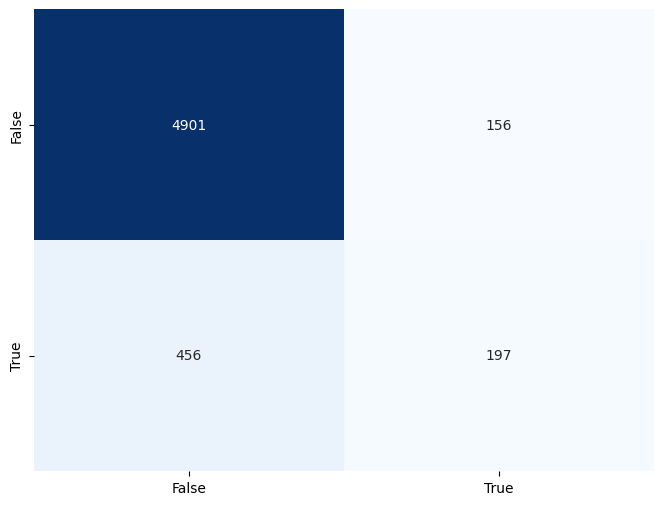

In [34]:
# Make predictions
y_pred = model1.predict(X_val_scaled)   
y_pred_proba = model1.predict_proba(X_val_scaled)[:,1]

# Evaluate the model
accuracy = accuracy_score(y_val, y_pred)
roc_auc = roc_auc_score(y_val, y_pred_proba)
conf_matrix = confusion_matrix(y_val, y_pred)

print(f"Accuracy: {accuracy:.4f}")
print(f"ROC AUC Score: {roc_auc:.4f}")
print("\nClassification Report:")
print(classification_report(y_val, y_pred))
print("\nConfusion Matrix:")
print(conf_matrix)

cm = confusion_matrix(y_val, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False, xticklabels=['False', 'True'], yticklabels=['False', 'True'])

In [35]:
# # Make predictions
# y_pred = model3.predict(X_val_scaled)
# y_pred_proba = model3.predict_proba(X_val_scaled)[:,1]

# # Evaluate the model
# accuracy = accuracy_score(y_val, y_pred)
# roc_auc = roc_auc_score(y_val, y_pred_proba)
# conf_matrix = confusion_matrix(y_val, y_pred)

# print(f"Accuracy: {accuracy:.4f}")
# print(f"ROC AUC Score: {roc_auc:.4f}")
# print("\nClassification Report:")
# print(classification_report(y_val, y_pred))
# print("\nConfusion Matrix:")
# print(conf_matrix)

# cm = confusion_matrix(y_val, y_pred)
# plt.figure(figsize=(8, 6))
# sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False, xticklabels=['False', 'True'], yticklabels=['False', 'True'])


# Optimizing

C:\Users\asus0\AppData\Local\Temp\ipykernel_36936\2531842603.py:4: FutureWarning: The NumPy global RNG was seeded by calling `np.random.seed`. In a future version this function will no longer use the global RNG. Pass `rng` explicitly to opt-in to the new behaviour and silence this warning.
  shap.summary_plot(shap_values, X_val_scaled, plot_type="bar", max_display=20)


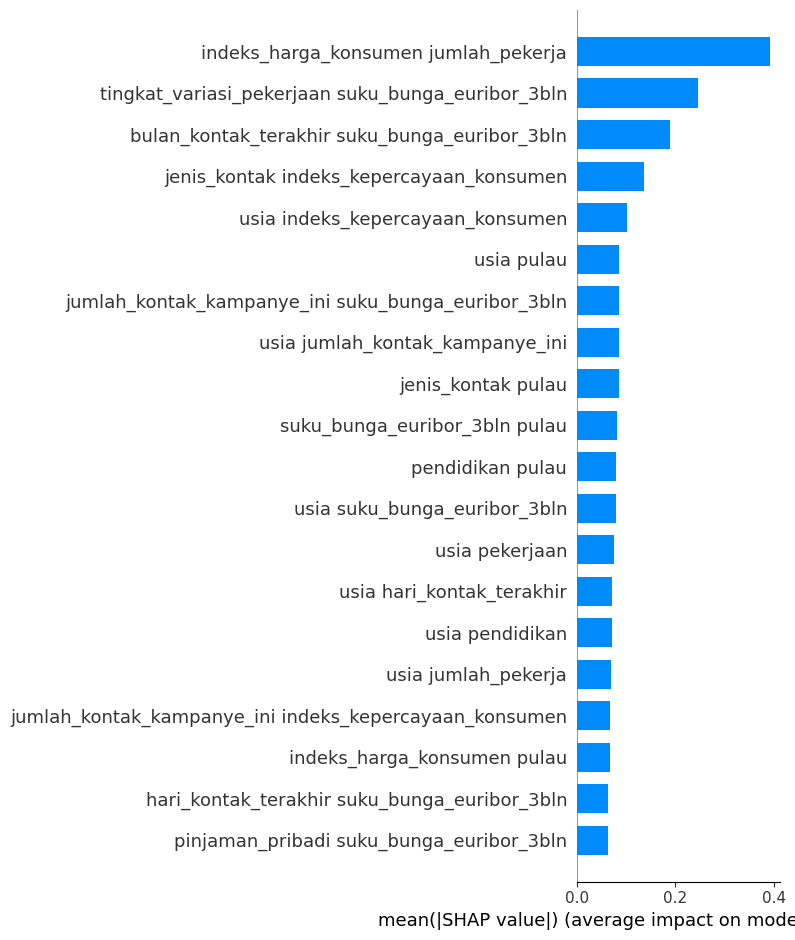

<Axes: title={'center': 'Feature Importance'}, xlabel='F score', ylabel='Features'>

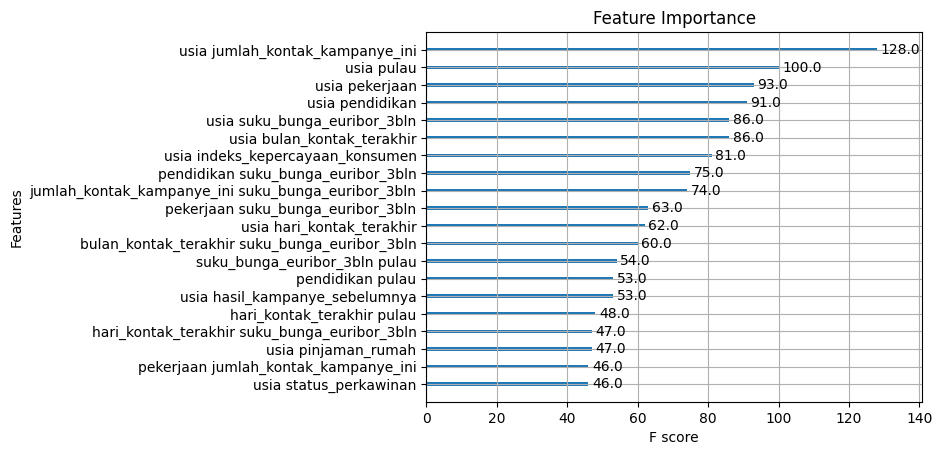

In [36]:
# Feature importance
explainer = shap.Explainer(model1)
shap_values = explainer.shap_values(X_val_scaled)
shap.summary_plot(shap_values, X_val_scaled, plot_type="bar", max_display=20)

plot_importance(model1, max_num_features=20, importance_type='weight', title='Feature Importance')

## Optuna

[I 2025-06-04 22:08:42,989] A new study created in memory with name: no-name-cfa1944f-b8dc-4626-a213-b4fd98a95f41
[I 2025-06-04 22:08:54,379] Trial 0 finished with value: 0.7878002411104527 and parameters: {'learning_rate': 0.10481692737783667, 'depth': 10, 'l2_leaf_reg': 4.2628929796775985, 'random_strength': 7.649607957845969, 'iterations': 979, 'border_count': 216, 'min_data_in_leaf': 31, 'bootstrap_type': 'No', 'leaf_estimation_iterations': 2, 'boosting_type': 'Plain', 'grow_policy': 'SymmetricTree'}. Best is trial 0 with value: 0.7878002411104527.
[I 2025-06-04 22:08:59,961] Trial 1 finished with value: 0.7847074741514878 and parameters: {'learning_rate': 0.02273574029520726, 'depth': 5, 'l2_leaf_reg': 9.0363926066809, 'random_strength': 3.257241188071864, 'iterations': 256, 'border_count': 203, 'min_data_in_leaf': 92, 'bootstrap_type': 'Bayesian', 'leaf_estimation_iterations': 5, 'boosting_type': 'Ordered', 'bagging_temperature': 4.063291272232164}. Best is trial 0 with value: 0.

Best trial:
  Value (AUC): 0.79623
  Params:
    learning_rate: 0.08990546873237987
    depth: 6
    l2_leaf_reg: 9.891693233487187
    random_strength: 1.1023284959814919
    iterations: 730
    border_count: 66
    min_data_in_leaf: 24
    bootstrap_type: MVS
    leaf_estimation_iterations: 3
    boosting_type: Ordered

Optimized Model Performance:
Accuracy: 0.8991
ROC AUC Score: 0.7962

Classification Report:
              precision    recall  f1-score   support

         0.0       0.91      0.98      0.95      5057
         1.0       0.64      0.27      0.38       653

    accuracy                           0.90      5710
   macro avg       0.77      0.63      0.66      5710
weighted avg       0.88      0.90      0.88      5710



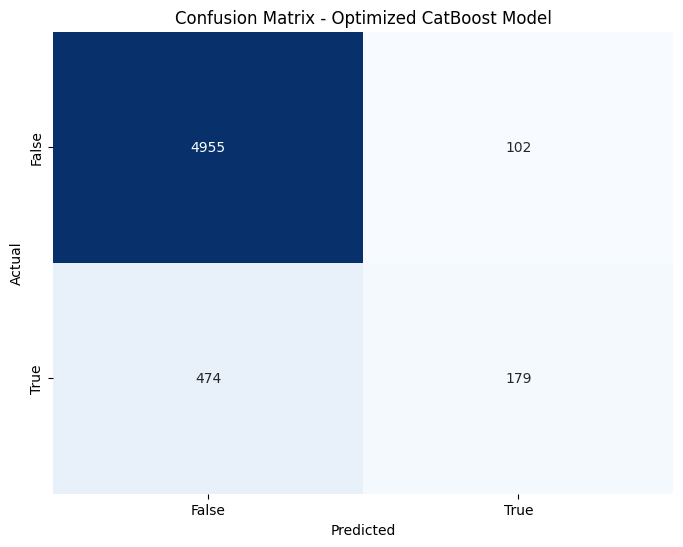

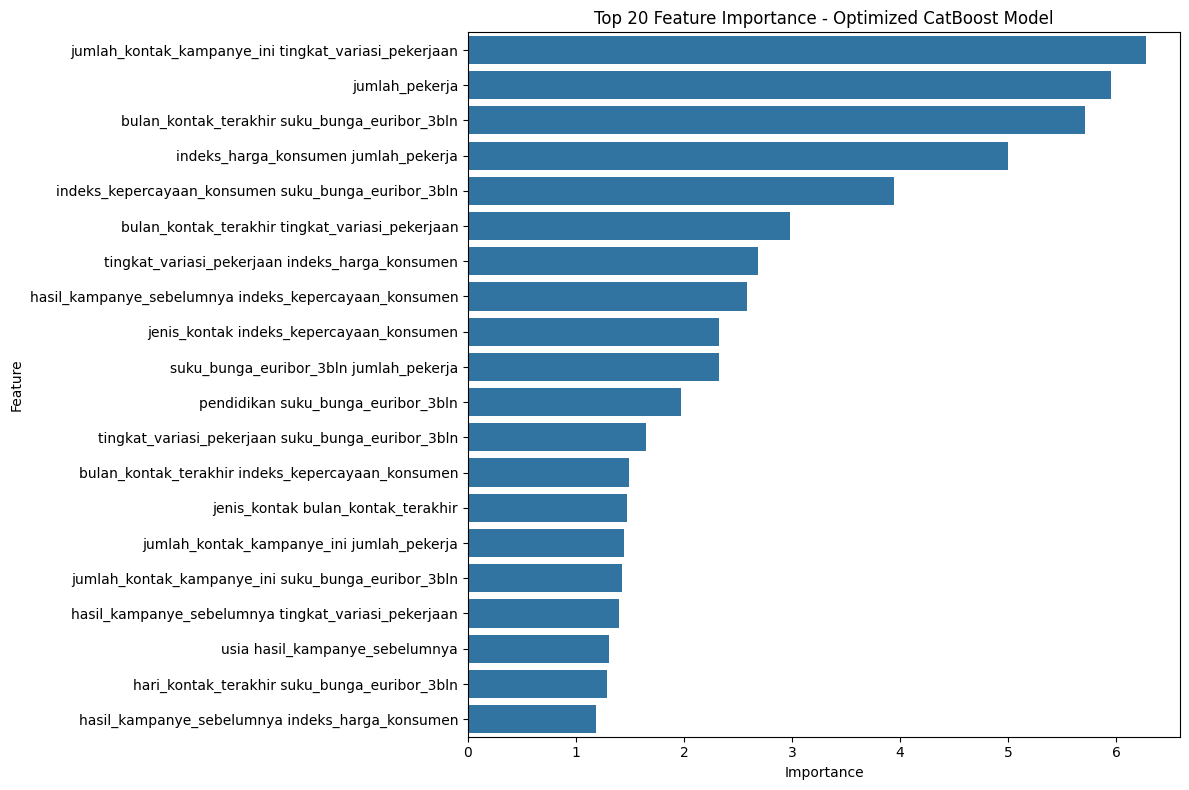

In [37]:
def objective(trial):
    # Define the hyperparameter search space
    param = {
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.3),
        'depth': trial.suggest_int('depth', 4, 10),
        'l2_leaf_reg': trial.suggest_float('l2_leaf_reg', 1, 10),
        'random_strength': trial.suggest_float('random_strength', 0.1, 10),
        'iterations': trial.suggest_int('iterations', 100, 1000),
        'border_count': trial.suggest_int('border_count', 32, 255),
        'min_data_in_leaf': trial.suggest_int('min_data_in_leaf', 1, 100),
        # 'scale_pos_weight': trial.suggest_float('scale_pos_weight', 1, 10),
        'bootstrap_type': trial.suggest_categorical('bootstrap_type', ['Bayesian', 'Bernoulli', 'MVS', 'No']),
        'leaf_estimation_iterations': trial.suggest_int('leaf_estimation_iterations', 1, 10),
        'random_seed': 42,
        'verbose': 0
    }
    
    # First choose boosting type
    param['boosting_type'] = trial.suggest_categorical('boosting_type', ['Ordered', 'Plain'])
    
    # For Ordered boosting, we must use SymmetricTree
    if param['boosting_type'] == 'Ordered':
        param['grow_policy'] = 'SymmetricTree'
    else:
        param['grow_policy'] = trial.suggest_categorical('grow_policy', ['SymmetricTree', 'Depthwise', 'Lossguide'])
    
    if param["bootstrap_type"] == "Bayesian":
        param["bagging_temperature"] = trial.suggest_float("bagging_temperature", 0, 10)
    elif param["bootstrap_type"] == "Bernoulli":
        param["subsample"] = trial.suggest_float("subsample", 0.1, 1, log=True)

    # Create model with current hyperparameters
    model = CatBoostClassifier(**param, eval_metric='AUC')
    
    # Train the model
    model.fit(
        X_train_scaled, y_train, 
        eval_set=[(X_val_scaled, y_val)],
        early_stopping_rounds=50,
        verbose=False
    )
    
    # Get validation AUC score
    preds = model.predict_proba(X_val_scaled)[:, 1]
    auc = roc_auc_score(y_val, preds)
    
    return auc

# Create and run the study
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=50, timeout=600)  # Set timeout to 10 minutes

# Display best parameters and score
print("Best trial:")
print(f"  Value (AUC): {study.best_value:.5f}")
print("  Params:")
for key, value in study.best_params.items():
    print(f"    {key}: {value}")

# Train final model with best parameters
best_params = study.best_params
best_params['random_seed'] = 42
best_params['verbose'] = 0
best_params['eval_metric'] = 'AUC'

best_model = CatBoostClassifier(**best_params)
best_model.fit(
    X_train_scaled, y_train, 
    eval_set=[(X_val_scaled, y_val)],
    early_stopping_rounds=50,
    verbose=False
)

# Evaluate the optimized model
y_pred = best_model.predict(X_val_scaled)
y_pred_proba = best_model.predict_proba(X_val_scaled)[:, 1]
accuracy = accuracy_score(y_val, y_pred)
roc_auc = roc_auc_score(y_val, y_pred_proba)

print(f"\nOptimized Model Performance:")
print(f"Accuracy: {accuracy:.4f}")
print(f"ROC AUC Score: {roc_auc:.4f}")
print("\nClassification Report:")
print(classification_report(y_val, y_pred))

# Plot confusion matrix
cm = confusion_matrix(y_val, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False, 
            xticklabels=['False', 'True'], yticklabels=['False', 'True'])
plt.title('Confusion Matrix - Optimized CatBoost Model')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

# Feature importance
feature_importance = best_model.get_feature_importance()
importance_df = pd.DataFrame({
    'Feature': X_train.columns,
    'Importance': feature_importance
}).sort_values(by='Importance', ascending=False)

plt.figure(figsize=(12, 8))
sns.barplot(x='Importance', y='Feature', data=importance_df.head(20))
plt.title('Top 20 Feature Importance - Optimized CatBoost Model')
plt.tight_layout()
plt.show()

# Save the best model for later prediction
model2_optimized = best_model

## RFE

In [38]:
# rfe = RFE(estimator=model2_optimized, step=1)
# rfe.fit(X_train_scaled, y_train)
# rfe_support = rfe.support_
# rfe_ranking = rfe.ranking_
# rfe_features = X_train_scaled.columns[rfe_support]
# print("RFE Selected Features:")
# print(rfe_features.tolist())
# # Create a new DataFrame with RFE selected features
# X_train_rfe = X_train_scaled[rfe_features]
# X_val_rfe = X_val_scaled[rfe_features]
# test_rfe = test_scaled[rfe_features]

# X_train_rfe

In [39]:
# model_rfe = model2_optimized
# model_rfe.fit(X_train_rfe, y_train, eval_set=(X_val_rfe, y_val), early_stopping_rounds=50, verbose=False)
# # Evaluate the RFE model
# y_pred_rfe = model_rfe.predict(X_val_rfe)
# y_pred_proba_rfe = model_rfe.predict_proba(X_val_rfe)[:, 1]
# accuracy_rfe = accuracy_score(y_val, y_pred_rfe)
# roc_auc_rfe = roc_auc_score(y_val, y_pred_proba_rfe)

# print(f"RFE Model Performance:")
# print(f"Accuracy: {accuracy_rfe:.4f}")
# print(f"ROC AUC Score: {roc_auc_rfe:.4f}")

# # Plot confusion matrix for RFE model
# cm_rfe = confusion_matrix(y_val, y_pred_rfe)
# plt.figure(figsize=(8, 6))
# sns.heatmap(cm_rfe, annot=True, fmt='d', cmap='Blues', cbar=False, 
#             xticklabels=['False', 'True'], yticklabels=['False', 'True'])
# plt.title('Confusion Matrix - RFE CatBoost Model')
# plt.xlabel('Predicted')
# plt.ylabel('Actual')

# Predict

In [40]:
# save the model
model2_optimized.save_model('catboost_model_rfe2.cbm')

# Save the parameters of the best model
with open('best_model_params.txt2', 'w') as f:
    for key, value in best_params.items():
        f.write(f"{key}: {value}\n")


In [44]:
# model_load = CatBoostClassifier()
# model_load.load_model('catboost_model_rfe.cbm')

# # Evaluate the optimized model
# y_pred = model_load.predict(X_val_scaled)
# y_pred_proba = model_load.predict_proba(X_val_scaled)[:, 1]
# accuracy = accuracy_score(y_val, y_pred)
# roc_auc = roc_auc_score(y_val, y_pred_proba)

# print(f"\nOptimized Model Performance:")
# print(f"Accuracy: {accuracy:.4f}")
# print(f"ROC AUC Score: {roc_auc:.4f}")
# print("\nClassification Report:")
# print(classification_report(y_val, y_pred))

# # Plot confusion matrix
# cm = confusion_matrix(y_val, y_pred)
# plt.figure(figsize=(8, 6))
# sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False, 
#             xticklabels=['False', 'True'], yticklabels=['False', 'True'])
# plt.title('Confusion Matrix - Optimized CatBoost Model')
# plt.xlabel('Predicted')
# plt.ylabel('Actual')
# plt.show()


In [45]:
# Id Column
test_id = pd.read_csv('D:/Data Quest Challenge DSI/validation_set.csv')['customer_number']

# Make predictions on the test set
test_predictions = model2_optimized.predict_proba(test_scaled)[:, 1]

# Create submission DataFrame
submission = pd.DataFrame({
    'customer_number': test_id,
    'berlangganan_deposito': test_predictions
})

# Save submission to CSV
submission.to_csv('submission3.csv', index=False)
print("Submission file created successfully!")

Submission file created successfully!
